# Exercise 4: Gaussian processes

## Problem 1: Moodle quiz

Answer the quiz in Moodle.

You can write below brief justifications for your answers for the yes/no questions, especially if you are unsure of your reasoning or have trouble understanding exactly what is being asked. I can then consider giving you points even if the automatic grading considered the answer wrong. You can also show the calculations you did to get the numerical answers.

In [1]:
# imports

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import torch

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10, 10]

### Question 1

When evaluating a new value $f(x^*)$ we know that the conditional is given by:

$$p(f(x^*|\mathbf{f})) = \mathcal{N}(K_{x^*, \mathbf{x}}K_{\mathbf{x}, \mathbf{x}}^{-1}\mathbf{f}, K_{x^*, x^*} - K_{x^*, \mathbf{x}}K_{\mathbf{x}, \mathbf{x}}^{-1}K_{\mathbf{x}, x^*}$$

where $K$ denotes the covariance matrix whose entries are defined by the kernel. In our case, we use an RBF kernel with $\ell=1.5$, $\lambda=2$, $x^*=1$, $x=2$ and $f(x=2)=3$. Note that when we use a symmetric kernel, like RBF, $K_{\mathbf{x}, x^*} = K_{x^*, \mathbf{x}}$ Using the formula above, we have:

In [2]:
### Here be the justifications and calculations, if so desired

def rbf(x, x_p, l, lam):
    return lam*np.exp( -(x-x_p)**2 / (2*l**2) )

cross_k = rbf(2, 1, 1.5, 2)
x_k = rbf(2, 2, 1.5, 2)
x_star_k = rbf(1, 1, 1.5, 2)

print(f"Cross-covariance: {cross_k}")
print(f"Covariance in data: {x_k}")
print(f"Covariance in data to evaluate: {x_star_k}")

post_mu = cross_k*3/x_k
post_var = x_star_k - cross_k**2/x_k

print(f"Posterior mean: {post_mu}")
print(f"Posterior var: {post_var}")

Cross-covariance: 1.6014748058336161
Covariance in data: 2.0
Covariance in data to evaluate: 2.0
Posterior mean: 2.402212208750424
Posterior var: 0.7176392231400908


### Question 2

See section 18.4 of the book

### Question 3

The smaller the length-scale parameter, the more "squiggly" our approximated function. This means that then a single observation doesn't really give us much information about the rest of the function; the values of the function are very highly uncorrelated, so we don't really learn how observations affect our inferred function very well. On the other hand, by setting $\ell \to \infty$, our covariance kernel returns pretty much a constant value for any pair of x's; the values are correlated over a long range. This is pretty much the basis for a linear model, for example in linear regression we are fitting a line using a training dataset, and we use this line to regress over unseen values.

### Question 4

By setting the hyperparameter $\sigma$ to 0, we are telling the model to assume that the observed $y$ was measured with no noise, so it will interpolate this datapoint perfectly.

### Question 5

The kernel we are using measures corellation as a function of distance, and it outputs very similar values for values that are close. They assume smoothness in the function, so if two points are close they will produce similar values.

## Problem 2: GPs and marginal likelihood

You are given a data set of $x$ and $y$ pairs as defined below. Your task is to learn a good **Gaussian Process regression** model for this.

Use the RBF kernel
$$
k(x, x') = \lambda e^{-\frac{1}{2l^2} (x-x')^2}
$$
with normal likelihood
$$
p(y|f(x)) = \mathcal{N}(f(x), \sigma^2)
$$
where $\sigma^2$ is the noise variance.

The model has three hyperparameters, $l$, $\lambda$ and $\sigma$, and we will be inspecting their effect on the result.

Write code that:
1. Estimates the posterior distribution of the latent function $f(x)$ and evaluate it for the dense grid of test points x_test. You should do this so that it works for any choice of the hyperparameters. Note that much of this is already available in the lecture notebook.
2. Optimizes the hyperparameters by maximizing the **marginal likelihood** $p(y|x,l,\lambda,\sigma)$ of the available data. You can use gradient descent in PyTorch or some other technique (e.g. gradient descent with analytic derivatives, or even some black-box optimization routine).
3. Prints the optimal values and the resulting marginal likelihood.
4. Plots the function. Make a plot that shows (a) The mean estimate of f() for the test points (the grid over x-axis), (b) the uncertainty of f(), and (c) the uncertainty of $y$ for the test points. You should also plot the training data in the same plot so that the plots are easier to interpret.

Now use the code you wrote to study the effect of the hyperparameters, by showing the plots and marginal likelihoods for different choices of the hyperparameters. Start by showing the result with the optimal parameters and then proceed to show pairs of plots where you always make one parameter clearly smaller or larger. Label your plots clearly (with something like "Large observation noise" if using excessively large $\sigma$ etc) and **explain** how each of the parameters influences the result.


### Notes

As stated here: https://stats.stackexchange.com/questions/386813/use-the-rbf-kernel-to-construct-a-positive-definite-covariance-matrix

The RBF kernel is numerically unstable due to its fast exponential decay. Therefore, sometimes it is usual to add a small epsilon term to the diagonal of covariance matrices generated by the kernel to improve the matrix' condition number.

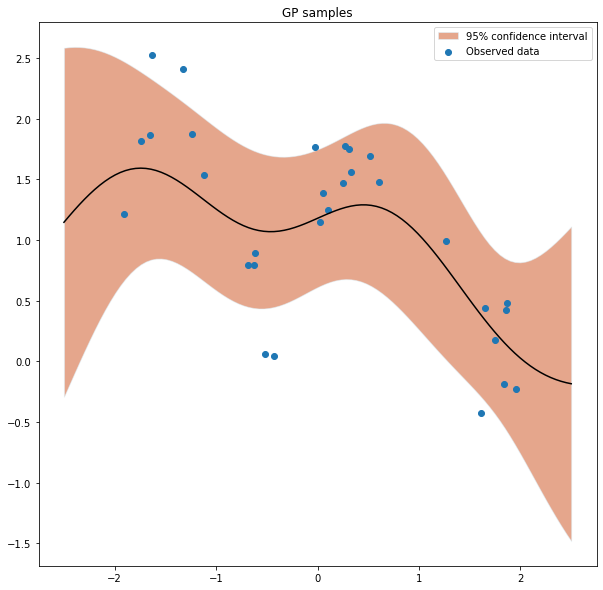

In [3]:
# THE DATA
x = torch.tensor([ 0.0504, -1.9066, -0.5220, -1.7397,  0.5151,  1.7474,  0.2499, -1.6334,
        -1.3278, -0.6832,  0.0248, -1.6533,  1.2656, -0.4293,  1.8606, -0.6216,
         0.2714,  0.0983, -0.6295, -1.1215,  1.8418,  1.6155,  1.9598,  1.8651,
         0.3304, -1.2396,  0.6092,  1.6508,  0.3112, -0.0261], dtype=torch.double)
y = torch.tensor([ 1.3866,  1.2162,  0.0608,  1.8141,  1.6938,  0.1754,  1.4721,  2.5264,
         2.4079,  0.7910,  1.1510,  1.8651,  0.9920,  0.0425,  0.4240,  0.8889,
         1.7757,  1.2457,  0.7961,  1.5359, -0.1856, -0.4273, -0.2238,  0.4841,
         1.5591,  1.8768,  1.4800,  0.4432,  1.7465,  1.7640], dtype=torch.double)
N = 30

# A REGULAR GRID OVER THE X-AXIS AS TEST POINTS
x_test = torch.linspace(-2.5, 2.5, 100)

# DEFINE THE KERNEL

# Simple RBF kernel with l controlling the smoothness
# and lam controlling the prior variance
def covMatrix(a, b, l=1.0, lam=torch.tensor([1.])):
    k = -0.5 * torch.square( a.reshape((len(a), 1)) - b.reshape((1, len(b))) )
    k /= l*l
    k += torch.log(lam)
    k = torch.exp(k)
    return k

# Compute the posterior with analytic expressions
# Epsilon term to avoid numerical instability due to the kernel
def posterior(y_obs, k_obs, k_pred, k_pred_obs, var = 1., epsilon = 1e-6):
    obs_len = k_obs.shape[0]
    pred_len = k_pred.shape[0]
    var_mat = var*torch.eye(obs_len)
    
    # Correction to avoid numeric instability
    k_obs += epsilon*torch.eye(obs_len)
    k_pred += epsilon*torch.eye(pred_len)
    
    inv_k_obs = torch.inverse(k_obs + var_mat)
    
    cov_matrix = k_pred - k_pred_obs @ inv_k_obs @ k_pred_obs.t()
    mean = k_pred_obs @ inv_k_obs @ y_obs
    return torch.distributions.multivariate_normal.MultivariateNormal(mean.flatten(), cov_matrix)

def plot_gp(distribution, obs_x=x, obs_y=y):
    preds = distribution.mean
    sigma = torch.sqrt(distribution.variance)

    # for pred in preds:
    plt.plot(x_test, preds, 'k')

    plt.fill_between(x_test.ravel(), preds-2*sigma, preds+2*sigma, 
                     label=r"95% confidence interval", alpha=0.5, 
                     edgecolor='#DEF3FD', facecolor='#CC4F1B')
    plt.scatter(obs_x, obs_y, label="Observed data")
    plt.title("GP samples")
    plt.legend()
    plt.show()
    return

# Marginal likelihood
def log_marginal_likelihood(x, y, theta, epsilon=1e-6):
    # theta[0] = l
    # theta[1] = lam
    # theta[2] = var
    N = x.shape[0]
    
    k = covMatrix(x, x, theta[0], theta[1]) + epsilon*torch.eye(N)
    var_mat = theta[2] * torch.eye(N)
    
    return 0.5*(-N*torch.log(torch.tensor([2*np.pi])) - torch.log(torch.det(k + var_mat)) - y_col.t()@torch.inverse(k+var_mat)@y_col)

cov_obs = covMatrix(x, x)
cov_pred = covMatrix(x_test, x_test)
cov_pred_obs = covMatrix(x_test, x)

y_col = y.reshape((len(y), 1))

post_test = posterior(y_col, cov_obs, cov_pred, cov_pred_obs)

plot_gp(post_test)

tensor(0.6425) tensor(1.4050) tensor(0.1097)


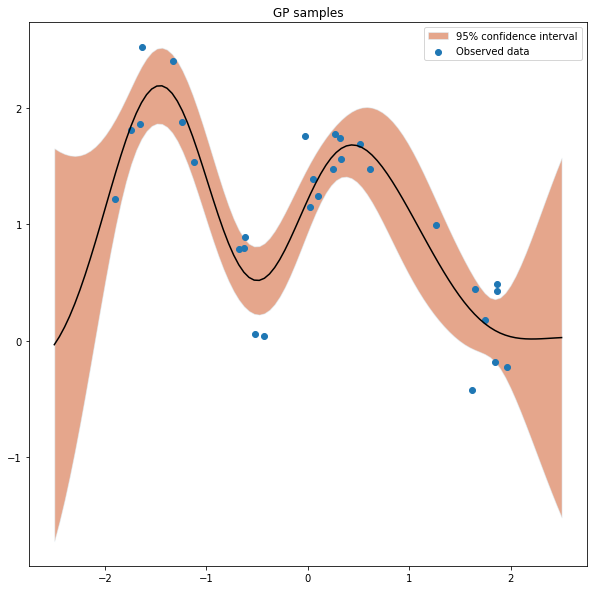

In [4]:
# Find optimal hyperparameters
# Note that you might want to optimize over log of these if using gradient descent
# l, lam, sigma = maximize_marginal_likelihood(...)

# Define the optimization algorithm
params = [torch.tensor([1.5, 2., 1.], requires_grad=True)]
optimizer = torch.optim.SGD(params, lr=1e-3)

# # Optimization loop
for i in range(5000):
    optimizer.zero_grad()
    loss = -log_marginal_likelihood(x, y_col, params[0])
    loss.backward()
    optimizer.step()

# maxiters = 300

# def closure():
#     optimizer.zero_grad()
#     l = -log_marginal_likelihood(x, y, params[0])
#     l.backward()
#     return l

# optimizer = torch.optim.LBFGS(params,max_iter=maxiters)
# optimizer.step(closure)

# Get the maximum value
mle_l, mle_lam, mle_var = params[0].detach()
print(mle_l, mle_lam, mle_var)

cov_obs = covMatrix(x, x, mle_l, mle_lam)
cov_pred = covMatrix(x_test, x_test, mle_l, mle_lam)
cov_pred_obs = covMatrix(x_test, x, mle_l, mle_lam)

y_col = y.reshape((len(y), 1))

post_test = posterior(y_col, cov_obs, cov_pred, cov_pred_obs, mle_var, 1e-5)

plot_gp(post_test)

In [5]:
# PLOTS
# Plot the latent function, its uncertainty and the uncertainty of the predictions y
# Do this for the optimal hyperparameters and also for bad configurations



## Problem 3: GPyTorch

In this exercise we practice using GPs with proper tools, rather than implementing inference from scratch.

We are given data that are pairs of univariate inputs $x$ and outputs $y$ that are constrained to be between zero and one. For instance, the input could be a dose of a drug (on some scale) and the output could be the probability that the drug has a positive effect in some population. We want to learn how $y$ depends on $x$ and realized we need a flexible model for this.

1. Start by reading the regression tutorial in https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html. 
2. Implement the model for the data provided below (using some kernel of your choice), using **exact inference** and **normal likelihood** for the observations. Do this so that you optimize over the kernel hyperparameters and report the results with an appropriate plot.
3. Change your code to use **variational approximation** but still use the normal likelihood. Check whether you get the same (or highly similar) result as with the exact inference. The documentation has clear pointers on how to do that, for instance in https://docs.gpytorch.ai/en/latest/examples/04_Variational_and_Approximate_GPs/Non_Gaussian_Likelihoods.html. Note that you now need to set both the model parameters and the likelihood parameters as trainable, since the likelihood parameters are no longer part of the model itself.
4. Continue with the variational approximation but now change the likelihood to **Beta distribution** so that you assume $y$ to be generated from a Beta distribution with the parameters
$$
    p(y|f) = \text{Beta}(s(f)b,(1-s(f))b)
$$
where $b$ is a scale parameter, $s()$ is the sigmoid function and $f$ is a latent function following a GP prior. Note that you do not need to implement this from scratch but the library has a direct implementation for the likelihood (see https://docs.gpytorch.ai/en/latest/likelihoods.html). Compare the result of modelling the data in this way with the previous results where you assumed normal likelihood for $y$ directly. What changed?

HINTS: 
- Whenever you plot something, remember to show also the uncertainty appropriately.
- Remember to write brief written explanation for what you see. How are the results different?
- The hyperparameter optimizer may sometimes converge to a local optimum where the data is modelled purely as noise. You can try to initialize the optimization routines better to avoid this, or you can try setting priors for these parameters. See https://docs.gpytorch.ai/en/latest/examples/00_Basic_Usage/Hyperparameters.html for examples on how to do this.
- For the Beta likelihood the parameter 's' is simply one extra hyperparameter. You can either leave it at some default value or give it a some prior and let the optimizer fit it. You should not use values that are very small since the latent function would then have very little effect -- for very small $s$ we just have uniform distribution over $y$ irrespective of $f$.

In [6]:
import gpytorch

# OBSERVED DATA
train_x = torch.tensor([0.5126, 0.0233, 0.3695, 0.0651, 0.6288, 0.9368, 0.5625, 0.0917, 0.1680,
        0.3292, 0.5062, 0.0867, 0.8164, 0.3927, 0.9651, 0.3446, 0.5678, 0.5246,
        0.3426, 0.2196, 0.9605, 0.9039, 0.9900, 0.9663, 0.5826, 0.1901, 0.6523,
        0.9127, 0.5778, 0.4935, 0.5012, 0.6410, 0.4883, 0.9442, 0.2780, 0.2305,
        0.4002, 0.2337, 0.5585, 0.4633, 0.0507, 0.6100, 0.3050, 0.7710, 0.6987,
        0.2694, 0.3509, 0.1588, 0.9979, 0.0690, 0.7652, 0.2706, 0.2667, 0.5845,
        0.6084, 0.4865, 0.5080, 0.5669, 0.2378, 0.0224, 0.0600, 0.8233, 0.3634,
        0.9148, 0.2383, 0.9255, 0.3103, 0.7075, 0.3455, 0.6943, 0.2243, 0.9852,
        0.6694, 0.8797, 0.3302, 0.5267, 0.7142, 0.9162, 0.3036, 0.5128])
train_y = torch.tensor([0.9473, 0.9803, 0.6330, 0.9250, 0.3311, 0.9499, 0.8616, 0.9144, 0.3090,
        0.3811, 0.8733, 0.9124, 0.3459, 0.4235, 0.9813, 0.2945, 0.8940, 0.9254,
        0.3932, 0.2734, 0.9696, 0.9025, 0.9856, 0.9716, 0.8138, 0.2813, 0.2329,
        0.8965, 0.8364, 0.9311, 0.9089, 0.5626, 0.9586, 0.9882, 0.1046, 0.2527,
        0.7312, 0.2641, 0.8285, 0.8893, 0.9742, 0.4065, 0.2098, 0.1219, 0.1360,
        0.2983, 0.4822, 0.3533, 0.9649, 0.9614, 0.1990, 0.0884, 0.0490, 0.7147,
        0.6823, 0.9583, 0.8776, 0.9316, 0.0573, 0.9834, 0.9565, 0.3792, 0.6348,
        0.9224, 0.1689, 0.9594, 0.1974, 0.3019, 0.1805, 0.1727, 0.2434, 0.9776,
        0.3741, 0.8168, 0.3170, 0.9061, 0.1242, 0.8877, 0.1660, 0.9657])
N = 80

# SET OF TEST POINTS (AGAIN A GRID OVER THE INPUT AXIS)
test_x = torch.linspace(0.0, 1.0, 100)

### Exact inference with normal likelihood

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


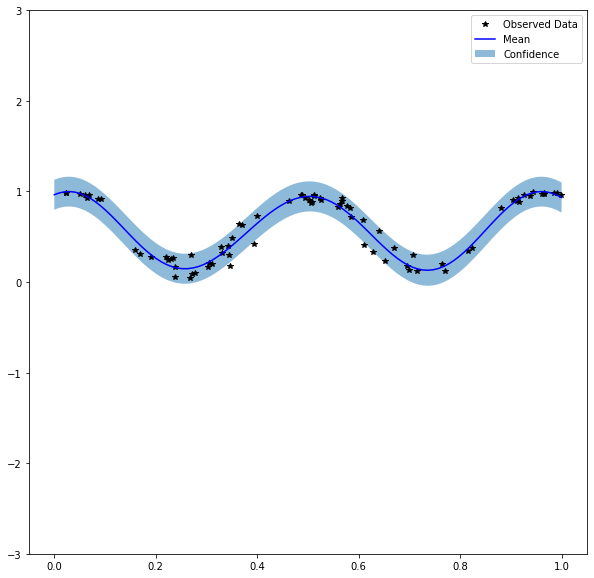

In [7]:

# FOR EACH OF THE THREE MODELS YOU NEED ROUGHLY THE FOLLOWING
# 1. Specify kernel and likelihood, as well as the function that provides the marginal likelihood
# 2. Define the optimization problem: Tell what parameters are to be learned etc. Initialize with reasonable values if having trouble with convergence.
# 3. Maximize marginal likelihood
# 4. Switch to evaluation mode and make predictions for the test samples
# 5. Plot results, paying attention also to uncertainty

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel = gpytorch.kernels.PeriodicKernel() # gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
model = ExactGPModel(train_x, train_y, likelihood, kernel)

training_iter = 1000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size([1000,]))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


### VA with Gaussian likelihood

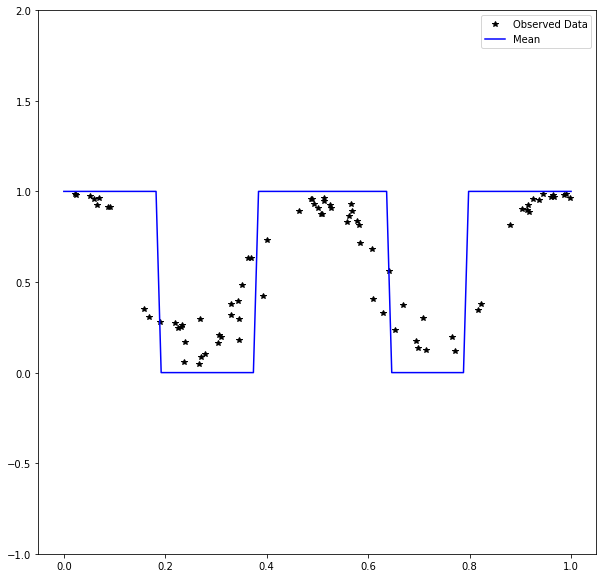

In [8]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.PeriodicKernel() # gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

training_iter = 1000

for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_samples = f_preds.sample(sample_shape=torch.Size([1000,]))

# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean'])

### VA with Beta likelihood

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


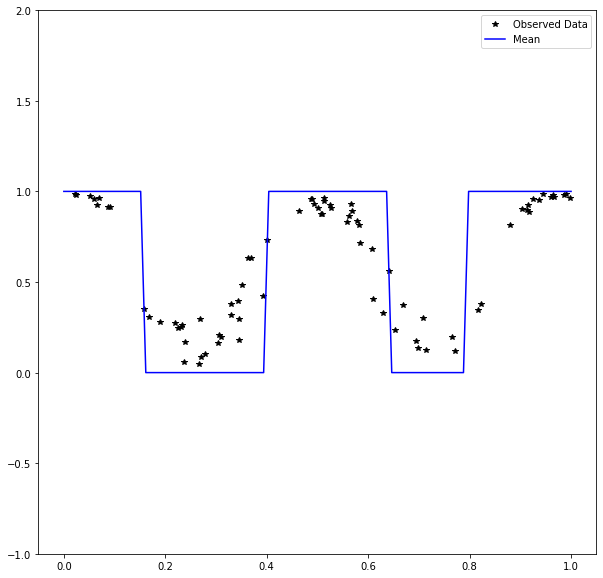

In [9]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BetaLikelihood(scale_prior = gpytorch.priors.GammaPrior(5., 5.))

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

training_iter = 1000

for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_samples = f_preds.sample(sample_shape=torch.Size([1000,]))

# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float()
    ax.plot(test_x.numpy(), pred_labels.numpy()[-1], 'b')
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean'])